## Import libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from time import time
from collections import Counter

## KNN Implementation


In [2]:
class KNNClassifier:
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        # Convert inputs to numpy arrays
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)
        
    def predict(self, X):
        X = np.asarray(X)
        predictions = []
        
        for x in X:
            # Calculate Euclidean distances
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            
            # Get k nearest neighbors (ensure k does not exceed dataset size)
            k = min(self.k, len(self.X_train))
            k_indices = np.argsort(distances)[:k]
            k_nearest_labels = self.y_train[k_indices]
            
            # Majority vote using Counter (handles ties better)
            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)
            
        return np.array(predictions)



## Load and preprocess

#### TO DO:

###### 1-Load data

###### 2-Sample equal number of samples from each class. find a reasonable number.

###### 3-Encode categorical values

###### 4-Keep these columns and drop the rest : grade, term, home_ownership, emp_length

###### 5-Split data to train, validation and test set

###### 6-Scale the data(normalization)

###### 7-The target column is "bad_loans"


In [3]:
def load_and_preprocess_data(path):
    
        # Load data with debug print
        print(f"Loading data from {path}")
        df = pd.read_csv(path)
        print(f"Initial dataframe shape: {df.shape}")
        print("\nInitial columns:", df.columns.tolist())
        
        # Check for required columns
        columns_to_keep = ['grade', 'term', 'home_ownership', 'emp_length', 'bad_loans']
        missing_cols = [col for col in columns_to_keep if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Keep only required columns
        df = df[columns_to_keep]
        print(f"\nShape after keeping required columns: {df.shape}")
        
        # Check for missing values
        print("\nMissing values before handling:")
        print(df.isnull().sum())
        
        # Handle missing values
        df['emp_length'] = df['emp_length'].fillna('missing')
        df = df.fillna('unknown')
        
        # Check class distribution
        print("\nClass distribution before balancing:")
        print(df['bad_loans'].value_counts())
        
        # Sample equal number from each class
        min_class_count = df['bad_loans'].value_counts().min()
        print(f"\nSampling {min_class_count} instances from each class")
        
        df_balanced = pd.concat([
            df[df['bad_loans'] == 0].sample(min_class_count, random_state=42),
            df[df['bad_loans'] == 1].sample(min_class_count, random_state=42)
        ])
        
        print("\nClass distribution after balancing:")
        print(df_balanced['bad_loans'].value_counts())
        
        # Encode categorical variables
        label_encoders = {}
        for column in ['grade', 'term', 'home_ownership', 'emp_length']:
            print(f"\nUnique values in {column} before encoding:", df_balanced[column].unique())
            le = LabelEncoder()
            df_balanced[column] = le.fit_transform(df_balanced[column].astype(str))
            label_encoders[column] = le
            print(f"Unique values in {column} after encoding:", df_balanced[column].unique())
        
        # Split features and target
        X = df_balanced.drop('bad_loans', axis=1)
        y = df_balanced['bad_loans']
        
        print(f"\nFeatures shape: {X.shape}")
        print(f"Target shape: {y.shape}")
        
        # Split into train, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
        
        print("\nSplit sizes:")
        print(f"Train: {X_train.shape[0]}")
        print(f"Validation: {X_val.shape[0]}")
        print(f"Test: {X_test.shape[0]}")
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=X.columns,
            index=X_train.index
        )
        X_val_scaled = pd.DataFrame(
            scaler.transform(X_val),
            columns=X.columns,
            index=X_val.index
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=X.columns,
            index=X_test.index
        )
        
        print("\nScaled data shapes:")
        print(f"X_train_scaled: {X_train_scaled.shape}")
        print(f"X_val_scaled: {X_val_scaled.shape}")
        print(f"X_test_scaled: {X_test_scaled.shape}")
        

        

        return (X_train_scaled, X_val_scaled, X_test_scaled,
                y_train, y_val, y_test,
                X.columns, label_encoders, scaler)
                
    


#### Training functions


In [4]:
def train_decision_tree(X_train, y_train, d):    
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_knn(X_train, y_train, k):
    model = KNNClassifier(k)  
    model.fit(X_train, y_train)
    return model

def train_adaboost(X_train, y_train, n):
    
    model = AdaBoostClassifier(n_estimators=n, random_state=42,algorithm="SAMME")
    model.fit(X_train, y_train)
    return model

def train_rf(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200,300],
        'max_depth': [5, 10, 15, None]
    }
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_parameters = {

       'n_estimators' :  grid_search.best_params_['n_estimators'],
        'max_depth' : grid_search.best_params_['max_depth']
    }
    return grid_search.best_estimator_,best_parameters,grid_search.best_score_



In [5]:
def compare_models(dt_accuracy, knn_accuracy, ab_accuracy, rf_accuracy):
    models = ['Decision Tree', 'KNN','Adaboost', 'Random Forest']
    accuracies = [dt_accuracy, knn_accuracy, ab_accuracy,rf_accuracy]

    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies)
    plt.title('Model Comparison - Test Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    plt.show()


def compare_models2(dt_test_acc, dt_val_acc, 
                   knn_test_acc, knn_val_acc, 
                   ab_test_acc, ab_val_acc, 
                   rf_test_acc, rf_val_acc):
    
    models = ['Decision Tree', 'KNN', 'Adaboost', 'Random Forest']
    val_accuracies = [dt_val_acc, knn_val_acc, ab_val_acc, rf_val_acc]
    test_accuracies = [dt_test_acc, knn_test_acc, ab_test_acc, rf_test_acc]

    x = np.arange(len(models))  # محل قرارگیری میله‌ها روی محور x
    width = 0.3  # عرض میله‌ها

    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(x - width/2, val_accuracies, width, label='Validation Accuracy', color='skyblue')
    bars2 = plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='orange')

    plt.title('Model Comparison: Validation vs Test Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(x, models)

    # افزودن مقدار هر میله بالای آن
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center')

    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center')

    plt.legend()
    plt.show()



## The main function

#### TO DO:

###### Use the defined functions to load the dataset and train the models.

###### You should optimize the hyperparameters. Maximum depth for DT and k for KNN and n_estimators for Adaboost.

###### Find the best DT, KNN, Adaboost and RF model and report the test accuracy.


Loading data from ./loan_sub.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_32756\3213627442.py:5: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Initial dataframe shape: (122607, 68)

Initial columns: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans', 'emp_length_num', 'grade_num', 'sub_grade_num', 'delinq_2yrs_zero', 'pub_rec_zer

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


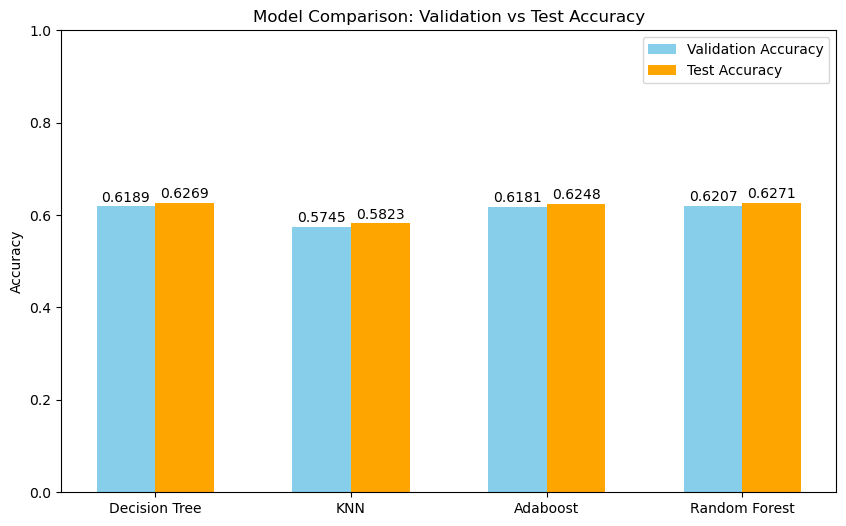

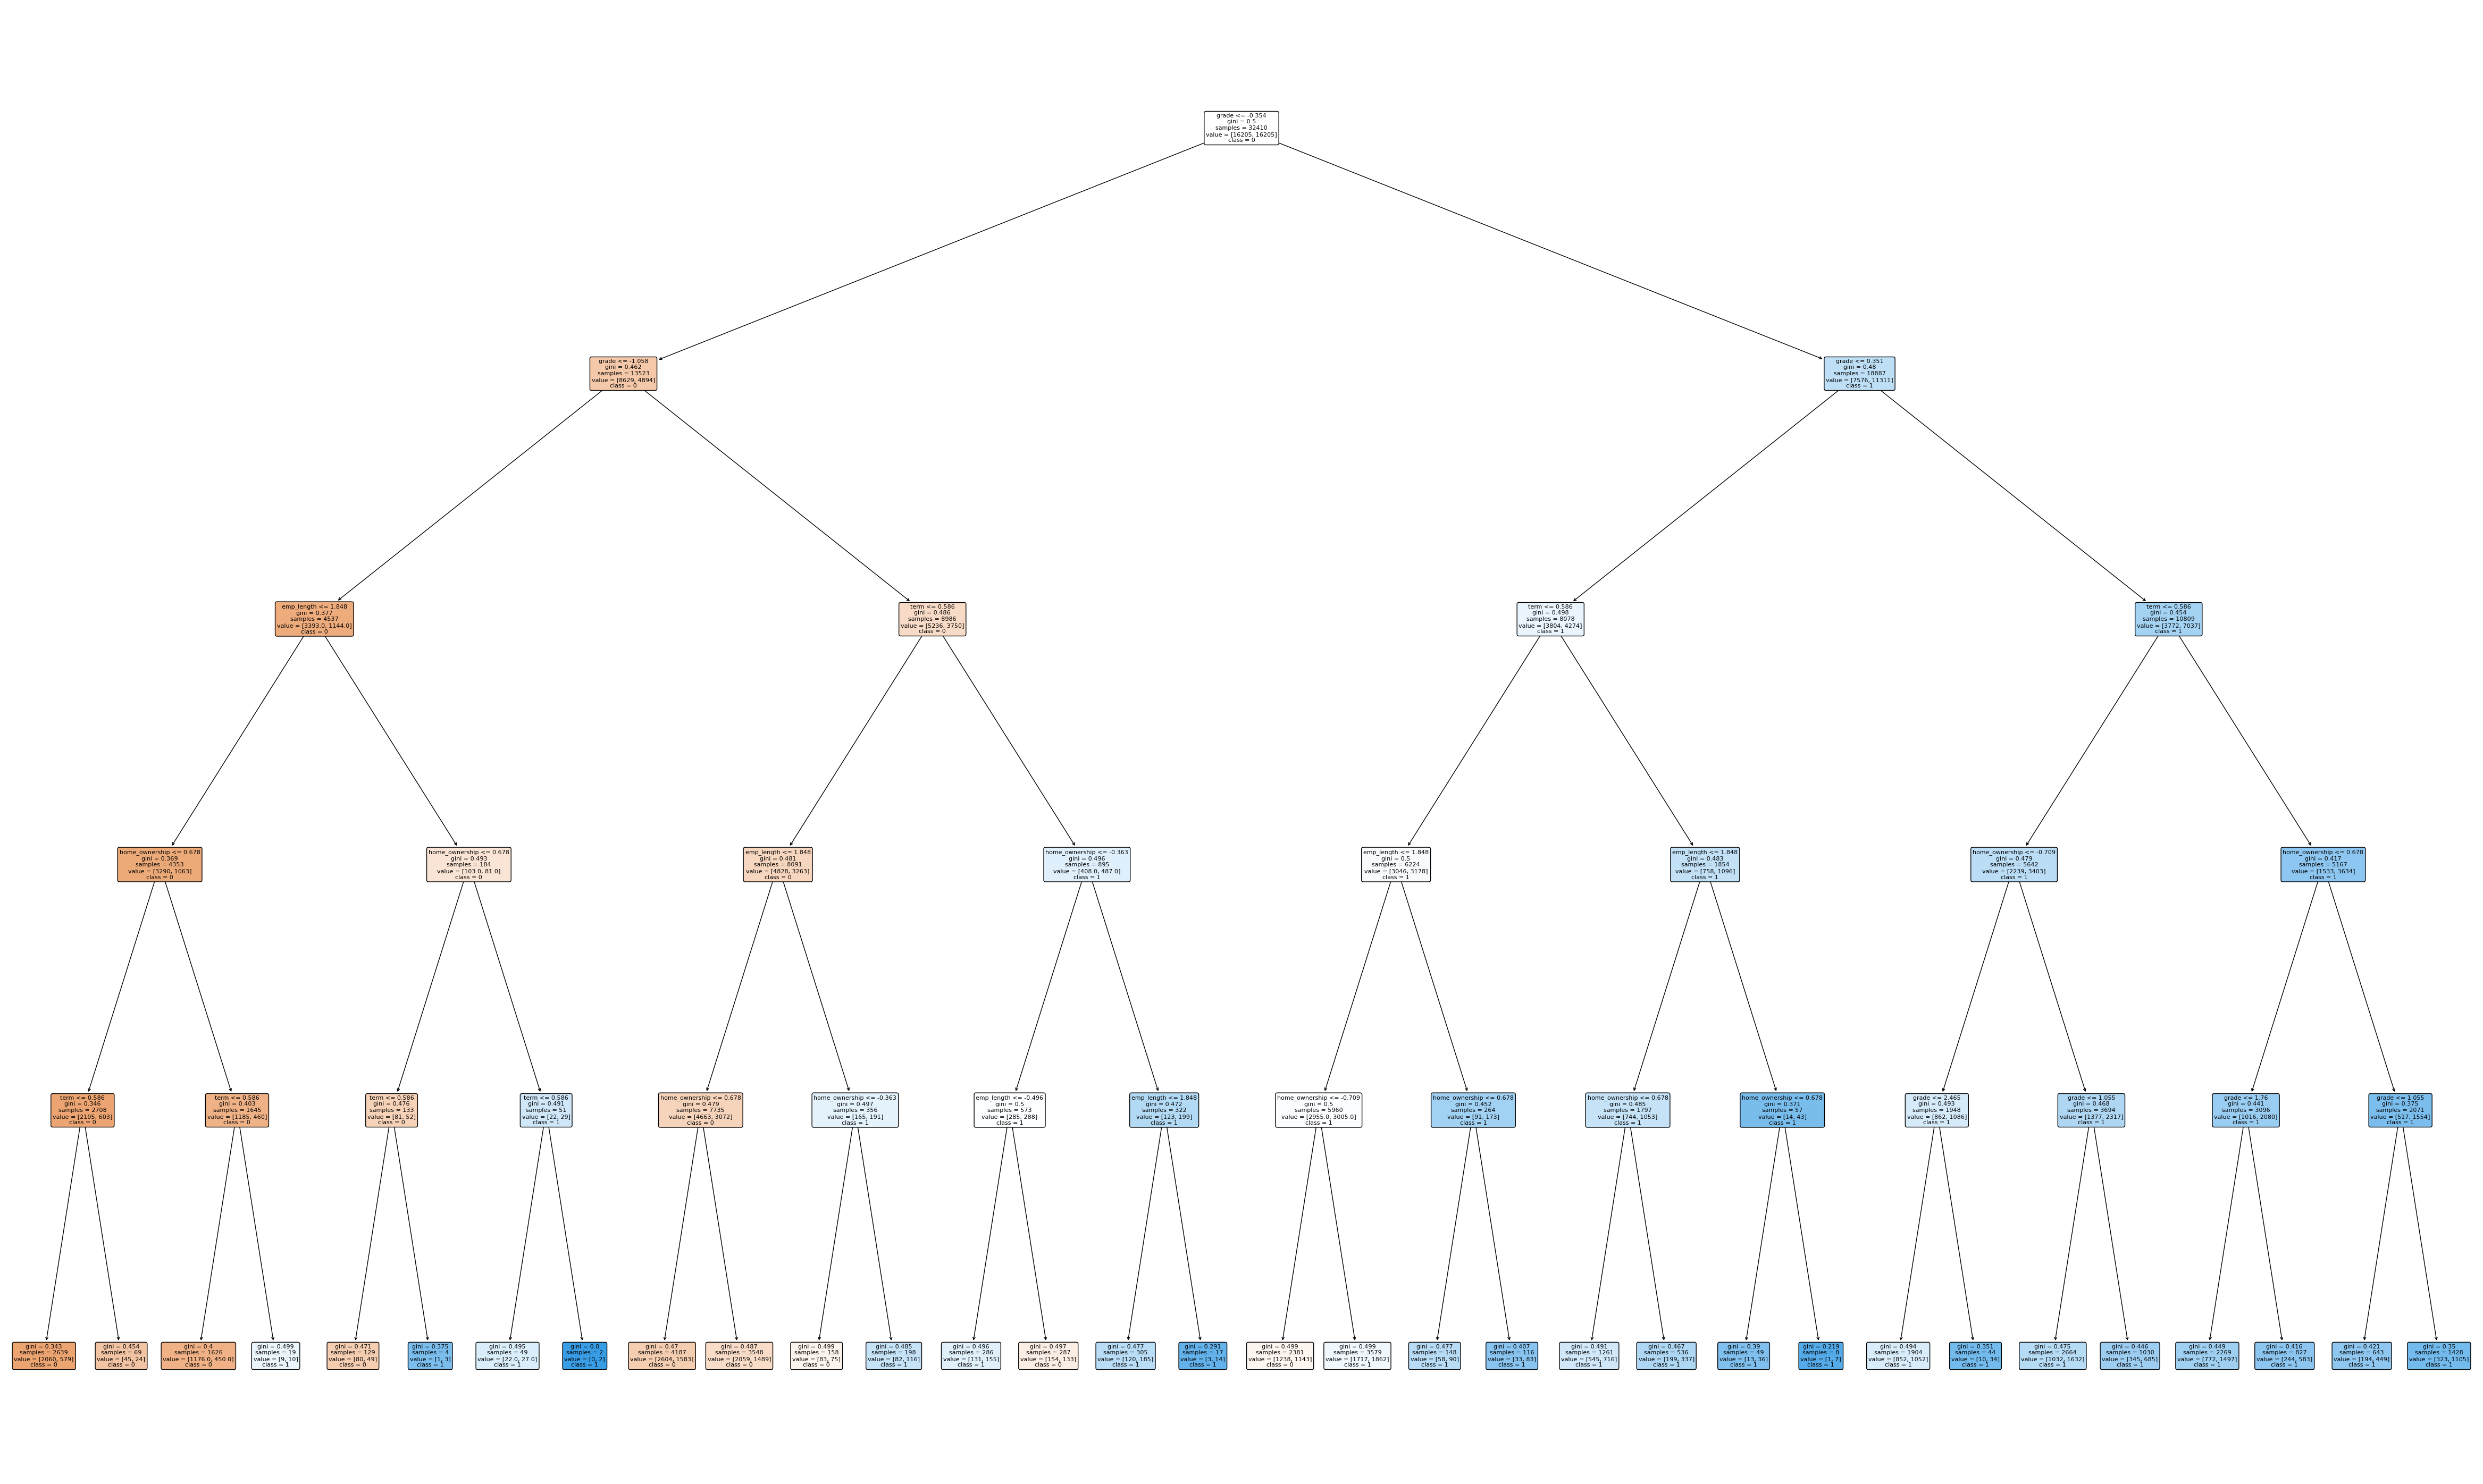

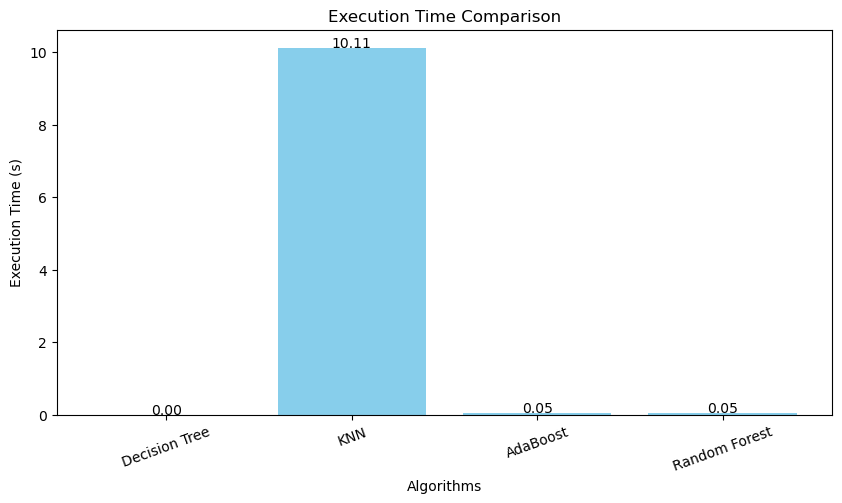

In [6]:
def main():
    
    # Load and preprocess data
    (X_train_scaled, X_val_scaled, X_test_scaled, 
     y_train, y_val, y_test, 
     columns, label_encoders, scaler) = load_and_preprocess_data('./loan_sub.csv')
    
    exec_time_dict = dict()

    print("Preprocessing is Finished")
    print("------------------------------------------------------------------------------------------------------")
    print('\n\n\n')
   
    ###############################################################################################################

    # Find best depth for Decision Tree
    
    print("Start Finding the Best max_depth for decision Tree : \n")

    depths = range(1, 11)
    dt_val_scores = []
    for d in depths:
        print("testing max_depth = ",d)
        dt_model = train_decision_tree(X_train_scaled, y_train, d)
        val_pred = dt_model.predict(X_val_scaled)
        dt_val_scores.append(accuracy_score(y_val, val_pred))
    
    best_depth = depths[np.argmax(dt_val_scores)]
    print(f"best max_depth for descition Tree : {best_depth}")
    best_dtmodel = train_decision_tree(X_train_scaled, y_train, best_depth)
    start = time()
    y_prediction1 = best_dtmodel.predict(X_test_scaled)
    stop = time()
    dt_test_acc = accuracy_score(y_test,y_prediction1 )
    dt_val_acc = max(dt_val_scores)
    print("Execution Time For Decision Tree  :  ",stop-start)
    exec_time_dict['Decision Tree'] = stop-start
    
    print("------------------------------------------------------------------------------------------------------")
    print('\n\n\n')

    ##############################################################################################################
    
    # Find best k for KNN
    print(f"start finding the best k for KNN Algorithm : \n")
    k_values = range(1,11)
    knn_val_scores = []
    for k in k_values:
        print("testing for k = ",k)
        knn_model = train_knn(X_train_scaled, y_train, k)
        val_pred = knn_model.predict(X_val_scaled)
        knn_val_scores.append(accuracy_score(y_val, val_pred))
    
    best_k = k_values[np.argmax(knn_val_scores)]
    print(f"best k for KNN : {best_k}\n\n\n")
    best_knn = train_knn(X_train_scaled, y_train, best_k)
    start = time()
    y_prediction2 = best_knn.predict(X_test_scaled)
    stop = time()
    print("Execution Time For KNN :  ",stop-start)
    exec_time_dict['KNN'] = stop-start
    knn_test_acc = accuracy_score(y_test,y_prediction2)
    knn_val_acc = max(knn_val_scores)
    print("------------------------------------------------------------------------------------------------------")
    print('\n\n\n')

    ###############################################################################################################
    
    # Find best n_estimators for AdaBoost
    print(f"start finding the best n_estimators for AdaBoost Algorithm : \n")
    n_estimators = [50, 100, 200]
    ab_val_scores = []
    for n in n_estimators:
        print("testing for n_estimators = ",n)
        ab_model = train_adaboost(X_train_scaled, y_train, n)
        val_pred = ab_model.predict(X_val_scaled)
        ab_val_scores.append(accuracy_score(y_val, val_pred))
    
    best_n = n_estimators[np.argmax(ab_val_scores)]
    print(f"best n_estimators  for AdaBoost : {best_n}\n\n\n")
    best_ab = train_adaboost(X_train_scaled, y_train, best_n)

    start = time()
    y_prediction3 = best_ab.predict(X_test_scaled)
    stop=  time()
    print("Execution Time For AdaBoost :  ",stop-start)
    exec_time_dict['AdaBoost'] = stop-start
    ab_test_acc = accuracy_score(y_test,y_prediction3)
    ab_val_acc = max(ab_val_scores)
    print("------------------------------------------------------------------------------------------------------")
    print('\n\n\n')
    ################################################################################################################
    print("Start Hyper Parameter tuning for RF Model : ")
    # combine the trainging set and validation set
    new_X_train = np.concatenate([X_train_scaled, X_val_scaled])
    new_y_train = np.concatenate([y_train, y_val])

    # Train Random Forest with GridSearch
    rf_model,best_params_for_rf,rf_val_acc = train_rf(new_X_train,new_y_train)
    start = time()
    y_prediction4 = rf_model.predict(X_test_scaled)
    stop = time()

    rf_test_acc = accuracy_score(y_test,y_prediction4 )
    print(f"best params for Random Forest : ",best_params_for_rf)
    print("Execution Time For Random Forest :  ",stop-start)
    exec_time_dict['Random Forest'] = stop-start
    print("------------------------------------------------------------------------------------------------------")
    print('\n\n\n')
    ################################################################################################################
    
    
    # Compare models
    compare_models2(dt_test_acc,dt_val_acc,knn_test_acc,knn_val_acc,ab_test_acc,ab_val_acc,rf_test_acc,rf_val_acc)
    
    # Plot decision tree
    plt.figure(figsize=(60,36))
    plot_tree(best_dtmodel, 
             feature_names=columns, 
             class_names=["0", "1"],       
             filled=True,
             rounded=True,
             fontsize=8
            )
    plt.show()



    # Extract keys and values
    algorithms = list(exec_time_dict.keys())
    times = list(exec_time_dict.values())

    # Plot the bar chart
    plt.figure(figsize=(10, 5))
    bars = plt.bar(algorithms, times, color='skyblue')

    # Labels and title
    plt.xlabel('Algorithms')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time Comparison')
    plt.xticks(rotation=20)  # Rotate labels for better readability

    # Display values above bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=10)

    # Show the plot
    plt.show()










if __name__ == "__main__":
    # os.system('cls' if os.name=='nt' else 'clear')
    main()
